# <span id=title style="color:#f37826"> LMPC - Simple example </span>
<br>

The notebook is based on the paper: U. Rosolia and F. Borrelli, "Learning Model Predictive Control for Iterative Tasks. A Data-Driven Control Framework," in _IEEE Transactions on Automatic Control_, vol. 63, no. 7, pp. 1883-1896, July 2018, doi: 10.1109/TAC.2017.2753460.

## <span style="color:#f37826">Table of contents</span>
1. [LMPC](#lmpc)
    1. [Recursive feasibility](#recursive_feasibility)
    1. [Asymptotic stability](#asymptotic_stability)
    1. [Improving performance](#improving_performance)
    1. [Avoiding mixed integer optimization](#avoiding_mixed_integer_optimization)
    1. [Model mismatch and disturbances](#model_mismatch_and_disturbances)
1. [Numerical example](#numerical_example)
    1. [Initial and optimal trajectory](#initial_and_optimal_trajectory)
    1. [Set up the LMPC optimization problem](#set_up_the_lmpc_optimization_problem)
    1. [Simulation](#simulation)
    1. [Results](#results)

## <span style="color:#f37826"> Housekeeping</span>
The following packages are required:
- numpy $\rightarrow$ Numerical computation
- casadi $\rightarrow$ Symbolic functions, algorithmic differentiation + easy to use interface to optimization routines
- matplotlib.pyplot $\rightarrow$ Plot graphs

In [1]:
import numpy as np
import casadi
import matplotlib.pyplot as plt

[Back to top](#title)

## <span id=lmpc style="color:#00549F"> 1. LMPC </span>

The LMPC's OCP formulation differs from the standard MPC formulation in the definition of the terminal cost and the terminal state constraint (marked in blue):

\begin{align}
    u(x) = \arg\min_{u_0,\dots,u_{N-1}} \sum_{k=0}^{N-1} &q(x_k, u_k) + \color{#00549F}{Q^{j-1}(x_N)} \\
    s.t. \quad x_0 &= x(t) \\
    x_{k+1} &= f(x_k,u_k), &\forall k\in[0,\dots, N-1]\\
    x_k &\in \mathcal{X}, &\forall k\in[0,\dots, N-1] \\
    u_k &\in \mathcal{U}, &\forall k\in[0,\dots, N-1] \\
    x_N &\in\color{#00549F}{SS^{j-1}}
\end{align}

The last state in the prediction horizon is forced onto one of the states of the so-called sampled safe set to achieve recursive feasibility.
The sampled safe set available at the current iteration $j$ contains all states visited in previous iterations which were successful in the sense that they drove the system into the origin.
This set can be interpreted as a collection of real world samples of the maximal stabilizable set [[1, Chp. 10.2]](#ref1).
Since it is collected from the actual environment, the overall algorithm is considered to "learn from the environment", thus Learning MPC.
To improve performance after each iteration, the terminal cost term is defined as the terminal state's cost-to-go, which is also available from previous trials. 


### <span id=recursive_feasibility style="color:#00549F">1.1 Recursive feasibility </span>

__Assumptions__
1. no disturbances
1. no model mismatch
1. same initial state in each iteration
1. (potentially poor) initial feasible trajectory available ($j=0$ in figure below)

__Lemmata__
1. The initial optimization problem is feasible
    - Since the system always starts in the same initial state and there is a feasible trajectory according to assumption 4, the initial OCP has at least one solution 
2. Given a feasible optimization problem at the current time step, the problem will also be feasible in the next time step
    - Suppose the optimization problem for the current time step $t$ is feasible and we obtained an optimal solution $[x^\ast_0,x^\ast_1,x^\ast_2]$ with corresponding inputs $[u^\ast_0,u^\ast_1]$ for a horizon of $N=2$
    - Due to the terminal constraint, the last state $x_2^\ast$ equals a state that has been visited in one of the previous trials. Since the safe set consists only of successful trajectories, there is a successor state of $x_2^\ast$ and a control input driving the system there, so that both state and input bounds are satisfied
    - Due to assumption 1 and 2, the system finds itself in the state $x^2(3)=x_1^\ast$ in the next time step $t+1$
    - The combinations of the shifted state trajectory and the successor state with least cost-to-go $[x_1^\ast, x_2^\ast, x^{1}(4)]$ and the shifted input sequence and the input related to the transition to the successor state $[u_1^\ast,u^1(3)]$ represent a feasible solution. This follows as $[x_1^\ast, x_2^\ast]$ and $u_1^\ast$ is known to be a feasible solution from the last optimization and $x^{1}(4)$ and $u^1(3)$ is known to be feasible from iteration $j=1$
    - Not talking about optimality, there is a state and input trajectory satisfying all constraints. Hence, if the OCP at time $t$ is feasible, implying that $x_N$ equals a state in the safe set, also the OCP at $t+1$ is feasible

__Proof via induction__

$\Rightarrow$ As the first optimization problem is feasible and all following optimization problems will be feasible, the LMPC approach guarantees recursive feasibility under the given conditions.

<br>

<img src="figures/schematic_lmpc.svg" alt="schematic_lmpc" style="width: 700px;"/>
<center> Fig. 1: Schematic lmpc </center>


### <span id=asymptotic_stability style="color:#00549F"> 1.3 Asymptotic stability </span>
...

### <span id=improving_performance style="color:#00549F"> 1.4 Improving performance</span>
...

### <span id=avoiding_mixed_integer_optimization style="color:#00549F"> 1.5 Avoiding mixed integer optimization </span>
To avoid solving a mixed integer problem, the terminal constraint can be relaxed by replacing the discrete sampled safe set by its convex hull [[1, Chp. 4.1]](#ref1):

\begin{align*}
    \text{conv}(SS) = \left\{ \sum_{i=1}^k \lambda^i \cdot x^i ~|~ x^i \in SS,~\lambda^i \ge 0,~i=1,...,k,~\sum_{i=1}^k \lambda^i=1 \right\}
\end{align*}

This formulation can be cast into an optimization problem by introducing three constraints and additional optimization variables $\lambda^i$
\begin{align*}
    x_N \in SS^{j-1} \quad \longrightarrow \quad &1.~x_N = \sum_{i=1}^k \lambda^i \cdot x_{\text{SS}}^i, \\[0.2em]
    &2.~\lambda^i \ge 0, \\[0.2em]
    &3.~\sum_{i=1}^k \lambda^i = 1
\end{align*}

The Q values, which also only exist for the discrete states in the sampled safe set, are approximated using a barycentric interpolation [[1, Chp. 13.2]](#ref1)

<span style="color:red"> How does the relaxation of the mixed integer problem affect the proof for recursive feasibility? </span>

### <span id=model_mismatch_and_disturbances style="color:#00549F"> 1.6 Model mismatch and disturbances </span>
<span style="color:red"> How do model mismatch and bounded disturbances affect the proof for recursive feasibility? </span>

<br>

<span id=ref1> [1] </span> Borrelli, F., Bemporad, A., & Morari, M. (2017). _Predictive Control for Linear and Hybrid Systems._ Cambridge: Cambridge University Press. doi:10.1017/9781139061759

[Back to top](#title)

## <span id=numerical_example style="color:#A11035"> 2. Numerical example </span>

In the example, the linear system 

\begin{align}
    x(k+1) &= \begin{bmatrix} 1 & 1 \\ 0 & 1 \end{bmatrix} \cdot x(k) + \begin{bmatrix}0\\1\end{bmatrix} B\cdot u(k) \\[0.4em]
    x(k) &\in \mathbb{R}^2 \\[0.2em]
    u(k) &\in \mathbb{R} \\[0.2em]
    x(0) &= [-14,2]^T \\[0.2em]
    x_F &= [0,0]^T 
\end{align}

is supposed to be driven into the origin from the initial state $x(0)$.
Both states and the input are subject to constraints.
The LMPC formulation has the following form.

\begin{align}
    \min_{u_0,\dots,u_{N-1}} \sum_{k=0}^{N-1} & \left(x_k^T\cdot Q \cdot x_k + u_k^T\cdot R \cdot u_k\right) + Q^{j-1}(x_N) \\
    s.t. \quad x_0 &= x(t) \\
    x_{k+1} &= A\cdot x_k + B\cdot u_k, \qquad\forall k\in[0,\dots, N-1]\\
    \underline{x} \le x_k &\le \overline{x}, \hspace{3.5cm}\forall k\in[0,\dots, N-1] \\
    \underline{u} \le u_k &\le \overline{u}, \hspace{3.5cm}\forall k\in[0,\dots, N-1] \\
    x_N &\in SS^{j-1}
\end{align}

All relevant information for the simulation, dynamic system and controller are stored in the following dictionaries.

__Sim__:
- Number of iterations $\rightarrow$ nIter
- Numerical tolerance for which origin is considered reached $||x||_2 < \text{tol} \rightarrow$ tol
- Initial state $\rightarrow$ x0
- Parameters for the optimization to obtain an initial feasible trajectory $\rightarrow$ N0, xMax0, xMin0

__Dyn__:
- System dimensions $\rightarrow$ nStates, nInputs
- State space matrices $\rightarrow$ A, B
- Bounds on states and inputs $\rightarrow$ xMax, xMin, uMax, uMin

__Lmpc__:
- Prediction horizon $\rightarrow$ N
- Weight matrices for quadratic cost function $\rightarrow$ Q, R
- Maximum array size for sampled safe set (keep dimensions of predefiend optimization problem constant) $\rightarrow$ nSafeSet
- QP-Solver $\rightarrow$ solver (qpoases, osqp, qrqp, ipopt)
- Solver options $\rightarrow$ expand (change MX to SX), print_time

In [2]:
Sim = { 'nIter':10, 'tol':1e-9, 'x0':[-14,2], 'N0':200, 'xMax0':[15,2], 'xMin0':[-15.-2] }
Dyn = { 'nStates':2, 'nInputs':1, 'A': [[1.,1.], [0.,1.]], 'B': [[0.],[1.]], 'xMax': [15.0, 15.0],
        'xMin': [-15.0, -15.0], 'uMax': [1.5], 'uMin': [-1.5],  }
Lmpc = { 'N':4, 'Q':[[1,0],[0,1]], 'R':1, 'nSafeSet':220, 'solver':'qpoases', 'expand':True, 'print_time':False }

### <span id=initial_and_optimal_trajectory style="color:#A11035"> 2.1 Initial and optimal trajectory </span>
The LMPC approach requires the initial sampled safe set to be non-empty.
Therefore, an initial suboptimal solution is acquired by solving the problem with a large prediction horizon and more restrictive bounds.
To obtain an optimal reference solution, the problem is solved using a large prediction horizon without manipulating the bounds.
Both optimizations are run using the following function.

In [3]:
def compute_optimal_trajectory( x0, N, Q, R, A, B, xMax, xMin, uMax, uMin):
    Ocp = casadi.Opti()
    x_ = Ocp.variable( len(A[0]), N+1 )
    u_ = Ocp.variable( len(B[0]), N )

    ## Constraints
    # Initial condition
    Ocp.subject_to( x_[:,0] == x0 )

    # System dynamics
    Ocp.subject_to( x_[:,1:] == casadi.DM(Dyn['A'])@x_[:,:-1] + casadi.DM(Dyn['B'])@u_ )

    # Bounds
    Ocp.subject_to( Ocp.bounded( xMin, x_[:,:-1], xMax ) )
    Ocp.subject_to( Ocp.bounded( uMin, u_, uMax ) )

    # Terminal constraint
    Ocp.subject_to( x_[:,-1] == [0,0] )

    ## Cost
    # Stage cost
    cost = []
    for ii in range(0,N):
        cost.append( x_[:,ii].T @ casadi.DM(Lmpc['Q']) @ x_[:,ii] + u_[:,ii].T @ casadi.DM(Lmpc['R']) @ u_[:,ii] )

    # Terminal cost
    cost.append( x_[:,-1].T @ casadi.DM(Lmpc['Q']) @ x_[:,-1] )

    # Solve the finite time optimal control problem (FTOCP)
    Ocp.minimize( sum(cost) )
    Ocp.solver( 'ipopt', {'expand':True, 'print_time':False, 'ipopt':{"print_level": 0}} )
    sol = Ocp.solve()

    # Store numerical solution
    X0 = sol.value( x_ )
    U0 = sol.value( u_ ).reshape( (1,-1) )
    
    return X0, U0

Run optimizations.

In [4]:
# Compute initial trajectory
X0, U0 = compute_optimal_trajectory( Sim['x0'], Sim['N0'], Lmpc['Q'], Lmpc['R'], Dyn['A'], Dyn['B'], Sim['xMax0'], 
                                     Sim['xMin0'], Dyn['uMax'], Dyn['uMin'] )
    
# Compute optimal reference trajectory
XOpt, UOpt = compute_optimal_trajectory( Sim['x0'], Sim['N0'], Lmpc['Q'], Lmpc['R'], Dyn['A'], Dyn['B'], Dyn['xMax'], 
                                         Dyn['xMin'], Dyn['uMax'], Dyn['uMin'] )


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



### <span id=set_up_the_lmpc_optimization_problem style="color:#A11035"> 2.2 Set up the LMPC optimization problem </span>
During simulation, the optimization problem will only by updated by the current state, sampled safe set and cost-to-go vector to reduce the overhead of creating the solver object.

In [5]:
if Lmpc['solver'] in ['qpoases', 'osqp', 'qrqp']:
    Ocp = casadi.Opti('conic')
else:
    Ocp = casadi.Opti();

Define symbolic variables for
- the states and inputs in the prediction horizon
- the multipliers used for the convex hull
- the parameters of the optimization problem that will be updated every time step (current system state)
- the parameters of the optimization problem which will be updated after each iteration (sampled safe set and corresponding cost-to-go)

In [6]:
xk_ = Ocp.variable( Dyn['nStates'], Lmpc['N']+1 )
uk_ = Ocp.variable( Dyn['nInputs'], Lmpc['N'] )
multConvexHull_ = Ocp.variable( Lmpc['nSafeSet'] )
xReal_ = Ocp.parameter( Dyn['nStates'] )
safeSet_ = Ocp.parameter( Dyn['nStates'], Lmpc['nSafeSet'] );
Qk_ = Ocp.parameter( Lmpc['nSafeSet'] );

Define constraints for
- initial condition $x_0 = x(t)$
- gap closing $x_{k+1} = A\cdot x_k + B\cdot u_k,~\forall k=[0,\dots,N-1]$
- bounds on states $\underline{x}\le x_k \le\overline{x},~\forall k=[0,\dots,N-1]$
- bounds on inputs $\underline{u}\le u_k \le\overline{u},~\forall k=[0,\dots,N-1]$
- enforcing last state to be inside the convex hull of the sampled safe set $x_N \in SS^{j-1}$ which introduces three additional constraints (see [1.5](#avoiding_mixed_integer_optimization))

In [7]:
Ocp.subject_to( xk_[:,0] == xReal_ )
Ocp.subject_to( xk_[:,1:] == casadi.DM(Dyn['A'])@xk_[:,:-1] + casadi.DM(Dyn['B'])@uk_ )
Ocp.subject_to( Ocp.bounded( Dyn['xMin'], xk_, Dyn['xMax'] ) )
Ocp.subject_to( Ocp.bounded( Dyn['uMin'], uk_, Dyn['uMax'] ) )
Ocp.subject_to( xk_[:,Lmpc['N']] == safeSet_@multConvexHull_ )
Ocp.subject_to( multConvexHull_ >= 0 )
Ocp.subject_to( casadi.sum1(multConvexHull_) == 1 )

Define stage and terminal cost. The latter is computed using a barycentric approximation.

In [8]:
cost = [];
for ii in range(0, Lmpc['N']):
    cost.append( xk_[:,ii].T @ casadi.DM(Lmpc['Q']) @ xk_[:,ii] + uk_[:,ii].T @ casadi.DM(Lmpc['R']) @ uk_[:,ii] )

cost.append( Qk_.T @ multConvexHull_ )

Ocp.minimize( sum(cost) )

Set solver and pass appropriate solver options.

In [9]:
if Lmpc['solver']=='qpoases':
    Ocp.solver('qpoases', {'expand':Lmpc['expand'], 'printLevel':'low'} )
elif Lmpc['solver']=='osqp':
    Ocp.solver('osqp', {'expand':Lmpc['expand'] } )
elif Lmpc['solver']=='qrqp':
    Ocp.solver('qrqp', {'expand':Lmpc['expand'], 'printLevel':'low'} )
elif Lmpc['solver']=='ipopt':
    Ocp.solver('ipopt', {'expand':Lmpc['expand'], 'print_time':Lmpc['print_time'], 'ipopt':{"print_level": 0}})
else:
    print('Selected solver not available')

### <span id=simulation style="color:#A11035"> 2.3 Simulation </span>
Define helper function to compute the cost-to-go for a given trajectory.

In [10]:
def compute_cost( x, u, Q, R ):
    cost = np.zeros( x.shape[1] )    
    cost[0] = np.dot( x[:,-1], np.dot(Q, x[:,-1]) )

    for ii in range(1, x.shape[1]):
        cost[ii] = cost[ii-1] + np.dot( x[:,-1-ii], np.dot(Q,x[:,-1-ii])) + np.dot( u[:,-ii], np.dot(R,u[:,-ii]) )
    
    return np.flip(cost)

Initialize arrays for states, inputs, cost-to-go, the sampled safe set and the corresponding cost-to-go.

In [11]:
X = [[] for k in range(Sim['nIter']) ]
U = [[] for k in range(Sim['nIter']) ]
Q = [None]*Sim['nIter']
data = {'x':np.append( X0, np.zeros((Dyn['nStates'],Lmpc['nSafeSet']-X0.shape[1])), axis=1 ),
        'Q':np.append( compute_cost( X0, U0, Lmpc['Q'], Lmpc['R'] ), np.zeros(Lmpc['nSafeSet']-X0.shape[1])) }

Run simulation.

In [12]:
print( 'Iteration j= 0: Cumulative cost = {0:2.5f} (initial trajectory)'.format(data['Q'][0]) )

for jj in range(0,Sim['nIter']):
    
    # Reset exit flag
    exitFlag = 0
    
    # Set initial time index
    tt = 0
    
    # Set initial state
    X[jj].append( Sim['x0'] )
    
    # Update ocp parameters for current iteration jj
    Ocp.set_value( safeSet_, data['x'] )
    Ocp.set_value( Qk_, data['Q'] )

    while exitFlag==0:
        # Update ocp parameters for current time step tt
        Ocp.set_value( xReal_, X[jj][-1] )

        # Solve the FTOCP at time tt of the jj-th iteration
        sol = Ocp.solve()

        # Simulate one step of the environment/ dynamic system
        U[jj].append( [sol.value(uk_[:,0])] )
        X[jj].append( np.add( np.dot(Dyn['A'],X[jj][-1]), np.dot(Dyn['B'],U[jj][-1]) ) )
        
        # Check termination conditions
        if np.dot( X[jj][-1], X[jj][-1] ) < Sim['tol']:
            exitFlag = 1

        # Increment time index
        tt += 1;

    # Compute cost-to-go for each state of iteration jj
    Q[jj] = compute_cost( np.array(X[jj]).T, np.array(U[jj]).T, Lmpc['Q'], Lmpc['R'] )
    
    print( 'Iteration j={0:2d}: Cumulative cost = {1:2.5f}'.format(jj+1, Q[jj][0]) )

    # Update safe set and Q function only for state values that are sufficiently different
    indLastValue = np.argmax(data['Q']==0)
    for ii in range( 0, len(X[jj]) ):
        if not any( np.linalg.norm( data['x'] - np.reshape(X[jj][ii],(2,1)), axis=0 )< 1e-06 ):
            data['x'][:,indLastValue+ii] = X[jj][ii]
            data['Q'][indLastValue+ii] = Q[jj][ii]

Iteration j= 0: Cumulative cost = 587.69922 (initial trajectory)
Iteration j= 1: Cumulative cost = 484.18534
Iteration j= 2: Cumulative cost = 484.18382
Iteration j= 3: Cumulative cost = 484.18354
Iteration j= 4: Cumulative cost = 484.18347
Iteration j= 5: Cumulative cost = 484.18345
Iteration j= 6: Cumulative cost = 484.18344
Iteration j= 7: Cumulative cost = 484.18344
Iteration j= 8: Cumulative cost = 484.18344
Iteration j= 9: Cumulative cost = 484.18344
Iteration j=10: Cumulative cost = 484.18344


### <span id='results' style="color:#A11035"> 2.4 Results </span>
The simulation results for the simple example show that a stationary solution is found in the first iteration.
All trajectories are plotted, but only the initial guess and the last iteration are added to the legend.
The intermediate solutions are not visible due to the fact that they are entirely covered by the last iteration.

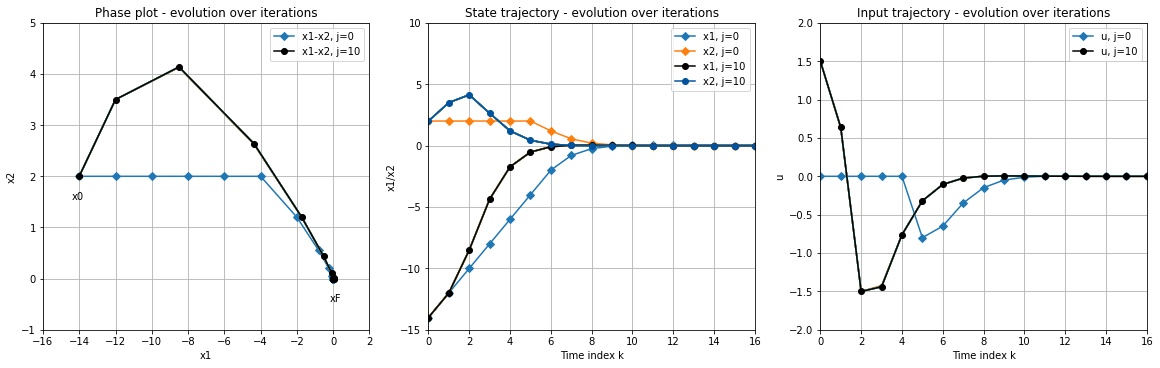

In [13]:
fig, (ax11,ax12,ax13) = plt.subplots( 1, 3, figsize=(16,5), constrained_layout=True )
ax11.set( title='Phase plot - evolution over iterations', xlim=(-16,2), ylim=(-1,5), xlabel='x1', ylabel='x2'); ax11.grid(True)
ax12.set( title='State trajectory - evolution over iterations', xlim=(0,16), ylim=(-15,10), xlabel='Time index k', ylabel='x1/x2' ); ax12.grid(True)
ax13.set( title='Input trajectory - evolution over iterations', xlim=(0,16), ylim=(-2,2), xlabel=('Time index k'), ylabel='u' ); ax13.grid(True)

# Phase plot
ax11.plot( X0[0,:], X0[1,:], marker='D', label='x1-x2, j=0' )
for list_i in X[0:-1]:
    ax11.plot( np.array(list_i)[:,0], np.array(list_i)[:,1] )
ax11.plot( np.array(X[-1])[:,0], np.array(X[-1])[:,1], color='k', marker='o', label='x1-x2, j={0:d}'.format(Sim['nIter']) )
ax11.legend(); ax11.annotate( 'x0', (-14.4, 1.55) ); ax11.annotate( 'xF', (-0.2, -0.45) )

# State trajectories
p121 = ax12.plot( X0.T, marker='D', label='j=0' )
for list_i in X[0:-1]:
    ax12.plot( np.array(list_i) )
p122 = ax12.plot( np.array(X[-1])[:,0], color='k', marker='o', label='j={0:d}'.format(Sim['nIter']) )
p123 = ax12.plot( np.array(X[-1])[:,1], color=(0,84/255,159/255), marker='o', label='j={0:d}'.format(Sim['nIter']) )
ax12.legend( handles=[p121[0],p121[1],p122[0],p123[0]], labels=('x1, j=0','x2, j=0','x1, j={0:d}'.format(Sim['nIter']),'x2, j={0:d}'.format(Sim['nIter'])) )

# Input trajectories
ax13.plot( U0[0,0:20].T, marker='D', label='u, j=0' )
for list_i in U[0:-1]:
    ax13.plot( np.array(list_i)  )    
ax13.plot( np.array(U[-1]), color='k', marker='o', label='u, j={0:d}'.format(Sim['nIter']) )
ax13.legend();

Comparing the last iteration of the simulation using the LMPC controller to the optimal solution obtained in [2.1](#initial_and_optimal_trajectory) shows that the resulting stationary trajectory is close to the optimal solution.

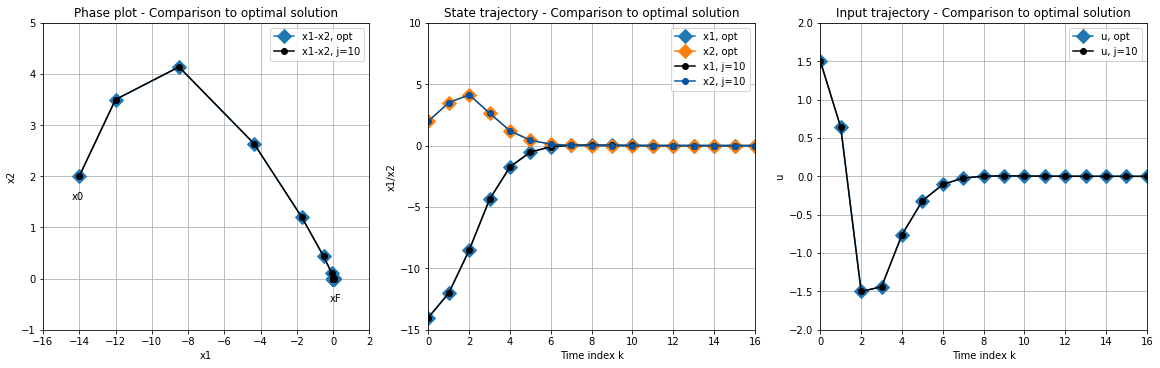

In [14]:
# Prepare figure
fig, (ax21,ax22,ax23) = plt.subplots( 1, 3, constrained_layout=True, figsize=(16,5) )
ax21.set( title='Phase plot - Comparison to optimal solution', xlim=(-16,2), ylim=(-1,5), xlabel='x1', ylabel='x2' ); ax21.grid(True)
ax22.set( title='State trajectory - Comparison to optimal solution', xlim=(0,16), ylim=(-15,10), xlabel='Time index k', ylabel='x1/x2' ); ax22.grid(True)
ax23.set( title='Input trajectory - Comparison to optimal solution', xlim=(0,16), ylim=(-2,2), xlabel=('Time index k'), ylabel='u' ); ax23.grid(True)

# Phase plot 
ax21.plot( XOpt[0,:], XOpt[1,:], marker='D', markersize=10, label='x1-x2, opt' )
ax21.plot( np.array(X[-1])[:,0], np.array(X[-1])[:,1], color='k', marker='o', label='x1-x2, j={0:d}'.format(Sim['nIter']) )
ax21.legend(); ax21.annotate( 'x0', (-14.4, 1.55) ); ax21.annotate( 'xF', (-0.2, -0.45) )

# State trajectories
p221 = ax22.plot( XOpt.T, marker='D', markersize=10 )
p222 = ax22.plot( np.array(X[-1])[:,0], color='k', marker='o', label='j={0:d}'.format(Sim['nIter']) )
p223 = ax22.plot( np.array(X[-1])[:,1], color=(0,84/255,159/255), marker='o', label='j={0:d}'.format(Sim['nIter']) )
ax22.legend( handles=[p221[0],p221[1],p222[0],p223[0]], labels=('x1, opt','x2, opt','x1, j={0:d}'.format(Sim['nIter']),'x2, j={0:d}'.format(Sim['nIter'])) )

# Input trajectories
ax23.plot( UOpt.T, marker='D', markersize=10, label='u, opt' )
ax23.plot( np.array(U[-1]), color='k', marker='o', label='u, j={0:d}'.format(Sim['nIter']) )
ax23.legend();

A look at the overall cost over the iteration reinforces the previous remarks.
The stationary solution is basically reached after the first iteration and is practically equal to the optimal solution.

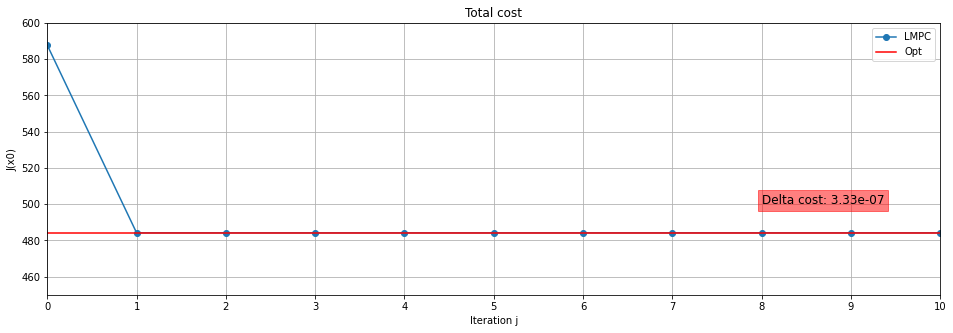

In [15]:
overallCost = [data['Q'][0]]
for q in Q:
    overallCost.append( q[0] )
costOpt = compute_cost(XOpt, UOpt, Lmpc['Q'], Lmpc['R'])[0]
                  
plt.figure( figsize=(16,5) )
plt.plot( np.arange(0,Sim['nIter']+1), overallCost, marker='o', label='LMPC' )
plt.plot( np.arange(0,Sim['nIter']+1), np.tile(costOpt,(Sim['nIter']+1,1)), color='r', label='Opt' )

ax3 = plt.gca(); ax3.set( xlim=(0,Sim['nIter']), ylim=(450,600), xlabel=('Iteration j'), ylabel='J(x0)', title='Total cost', xticks=np.arange(0,Sim['nIter']+1) ); ax3.grid(True)
ax3.legend(); ax3.annotate( 'Delta cost: {0:2.2e}'.format( overallCost[-1]-costOpt), (8, 500), size=12, bbox=dict(facecolor='red', alpha=0.5, edgecolor='red') );

[Back to top](#title)